Here we remove all but one parameter from the dictionary of free parameters.

Parameters "popped" from this dictionary are frozen only 'a' is left and free to vary.


In [1]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS



Next we pick a random point between 
a=0.01 and a=0.03
we instance a model at this random location in a. 
We then find rheobase and take efel measurements at 1.5 and 3.0 rheobase for the Izhikitich model. 

Then we use GA optimization to find the model that produced the measurements, as a type of inversion.

Jump to cells 27 and 28. You can see there that 

the error surface is highly intractable for some measurements, and for other measurements its a simple well with no ripples.

In [2]:
import efel
import pandas as pd
import seaborn as sns
list(efel.getFeatureNames());
from utils import dask_map_function

import bluepyopt as bpop
import bluepyopt.ephys as ephys
import pickle
from sciunit.scores import ZScore
from sciunit import TestSuite
from sciunit.scores.collections import ScoreArray
import sciunit
import numpy as np
from neuronunit.optimisation.optimization_management import dtc_to_rheo, switch_logic,active_values
from neuronunit.tests.base import AMPL, DELAY, DURATION

import quantities as pq
PASSIVE_DURATION = 500.0*pq.ms
PASSIVE_DELAY = 200.0*pq.ms
import matplotlib.pyplot as plt
from bluepyopt.ephys.models import ReducedCellModel
import numpy
from neuronunit.optimisation.optimization_management import test_all_objective_test
from neuronunit.optimisation.optimization_management import check_binary_match, three_step_protocol,inject_and_plot_passive_model
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
import copy

import numpy as np


simple_cell = ephys.models.ReducedCellModel(
        name='simple_cell',
        params=MODEL_PARAMS["IZHI"],backend="IZHI")  
simple_cell.backend = "IZHI"


# Now we can print out a description of the cell

model = simple_cell
model.params = {k:np.mean(v) for k,v in model.params.items() }
from make_allen_tests import AllenTest

from sciunit.scores import ZScore
tests = pickle.load(open("processed_multicellular_constraints.p","rb"))
nu_tests = tests['Hippocampus CA1 pyramidal cell'].tests
nu_tests[0].score_type = ZScore

simulated_experiment = True
features = None
allen = True
from collections.abc import Iterable

if simulated_experiment:
    while features is None:
        aug_nu_tests, OM, target = test_all_objective_test(MODEL_PARAMS["IZHI"],
                                                           model_type="IZHI",
                                                           protocol={'allen':False,
                                                                     'elephant':True})
        target = three_step_protocol(target)
        if hasattr(target,'everything'):
            features = copy.copy(target.everything)
            
            check_list = {key:feat for key,feat in features.items() if not feat is None and type(feat) is not type(Iterable) and feat !=0 and feat !=1 }
            check_list.pop('depol_block_1.5x',None)
            check_list.pop('is_not_stuck_3.0x',None)
            check_list.pop('is_not_stuck_1.5x',None)
            scale = 2.0/len(check_list)
            '''
            if scale > 0.009999:
                print('not high enough definition')
                features = None
                continue
            '''
            if allen:
                simple_cell.allen = None
                simple_cell.allen = True

                tests = pickle.load(open("allen_NU_tests.p","rb"))
                print('allen cell',tests[0].name)
                nu_tests = tests[0]
                for t in nu_tests:
                    to_pop = []
                    if t.name in features.keys():
                        if features[t.name] is not None:
                            t.set_observation(features[t.name])
                            if t.observation['mean'] is not None:
                                t.observation['std'] = np.abs(np.mean(t.observation['mean']))
                        to_pop.append(t.name)
                        
                    [ features.pop(i,None) for i in to_pop ]

sub_MODEL_PARAMS = copy.copy(MODEL_PARAMS['IZHI'])

subset = list(sub_MODEL_PARAMS.keys())
tg = target.dtc_to_gene(subset_params=subset)
assert len(tg)==len(subset)

Random simulated data tests made
allen cell 504615116


In [3]:
features = target.everything


for key,feat in features.items():
    if isinstance(feat, int):
        print(key,feat)
features
nu_tests;

In [4]:

big_list = []
for tt in aug_nu_tests.values():
    tt.core = None
    tt.core = True
    big_list.append(tt)
big_list.extend(nu_tests)
nu_tests = big_list

In [5]:
#!ls -ltr *.p
import pickle

no_list = pickle.load(open("too_rippled_b.p","rb"))
yes_list = pickle.load(open("tame_b.p","rb"))
yes_list
yes_list = ['voltage_base_1.5x','peak_voltage_3.0x','voltage_base_1.5x','Spikecount_1.5x','Spikecount_3.0x','ohmic_input_resistance_vb_ssse_1.5x']

In [6]:
#yes_list = ['peak_voltage_3.0x','voltage_base_1.5x','ohmic_input_resistance_vb_ssse_1.5x','Spikecount_1.5x','Spikecount_3.0x']

In [7]:
 
class NUFeatureAllenMultiSpike(object):
    def __init__(self,test,model,cnt,target,check_list,spike_obs,print_stuff=False):
        self.test = test
        self.model = model
        self.check_list = check_list
        self.spike_obs = spike_obs
        self.cnt = cnt
        self.target = target
        self.print_stuff = print_stuff
    def calculate_score(self,responses):
        if not 'features' in responses.keys():# or not 'model' in responses.keys():
            return 1000.0
        check_list = self.check_list

    
        features = responses['features']

        
        feature_name = self.test.name
        delta0 = np.abs(features['Spikecount_3.0x']-np.mean(self.spike_obs[0]['mean']))
        delta1 = np.abs(features['Spikecount_1.5x']-np.mean(self.spike_obs[1]['mean']))
        if feature_name not in features.keys():
            return 1000.0+(delta0+delta1)
        
        if features[feature_name] is None:
            return 1000.0+(delta0+delta1)
            
        if type(features[self.test.name]) is type(Iterable):
            features[self.test.name] = np.mean(features[self.test.name])
        self.test.observation['std'] = np.abs(np.mean(self.test.observation['mean']))
        self.test.observation['mean'] = np.mean(self.test.observation['mean'])            
        self.test.set_prediction(np.mean(features[self.test.name]))
        
        if 'Spikecount_3.0x'==feature_name or 'Spikecount_1.5x'==feature_name:
            delta = np.abs(features[self.test.name]-np.mean(self.test.observation['mean']))
            #print('spike count good?',delta)
            
            return delta
        else:


            if feature_name in check_list:
                if features[feature_name] is None:
                    return 1000.0+(delta0+delta1)
                from sciunit.scores import ZScore
                self.test.score_type = ZScore
                score_gene = self.test.feature_judge()
                if score_gene is not None:
                    if score_gene.log_norm_score is not None:
                        delta = np.abs(float(score_gene.log_norm_score))
                    else:
                        if score_gene.raw is not None:
                            delta = np.abs(float(score_gene.raw))
                        else:
                            delta = None

                else:
                    delta = None
                        #if delta==np.inf or np.isnan(delta):
                        #    if score_gene.raw is not None:
                        #        delta =  np.abs(float(score_gene.raw))
                if delta is None:
                    delta = np.abs(features[self.test.name]-np.mean(self.test.observation['mean']))


                if np.nan==delta or delta==np.inf:
                    delta = np.abs(features[self.test.name]-np.mean(self.test.observation['mean']))

                    #delta = 1000.0+(delta0+delta1)
                return delta
            else:
                return 0.0
                #print(delta,delta0,delta1)
                #if (delta0 == 0 and delta1 == 0) and delta>1:
                    #print(feature_name)
                    #print(delta)
                    #print('feature,spike count 1 difference, spike count 2 difference')
                    #delta = 0.0
                #    pass
                ##
                # Here was working old line:
                #if str('delta') in list(locals()):
                #print(feature_name)
                #+(delta0+delta1)
            #else:
            #    return 0.0
            ##
            #return delta
   
objectives = []
spike_obs = []
for tt in nu_tests:
    if 'Spikecount_3.0x' == tt.name:
        spike_obs.append(tt.observation)
    if 'Spikecount_1.5x' == tt.name:
        spike_obs.append(tt.observation)
spike_obs = sorted(spike_obs, key=lambda k: k['mean'],reverse=True)
             

for cnt,tt in enumerate(nu_tests):
    feature_name = '%s' % (tt.name)
    if feature_name in check_list:
        if 'Spikecount_3.0x' == tt.name or 'Spikecount_1.5x' == tt.name:
            ft = NUFeatureAllenMultiSpike(tt,model,cnt,target,check_list,spike_obs)
            objective = ephys.objectives.SingletonObjective(
                feature_name,
                ft)
            objectives.append(objective)


        
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 
      




lop={}
from bluepyopt.parameters import Parameter
for k,v in MODEL_PARAMS["IZHI"].items():
    p = Parameter(name=k,bounds=v,frozen=False)
    lop[k] = p

print(lop)
simple_cell.params = lop


{'C': <bluepyopt.parameters.Parameter object at 0x7f736618ea90>, 'k': <bluepyopt.parameters.Parameter object at 0x7f7351ab76d0>, 'vr': <bluepyopt.parameters.Parameter object at 0x7f7351ab7650>, 'vt': <bluepyopt.parameters.Parameter object at 0x7f7351ab7210>, 'vPeak': <bluepyopt.parameters.Parameter object at 0x7f7351ab7610>, 'a': <bluepyopt.parameters.Parameter object at 0x7f7351ab77d0>, 'b': <bluepyopt.parameters.Parameter object at 0x7f7351ab7990>, 'c': <bluepyopt.parameters.Parameter object at 0x7f7351ab7810>, 'd': <bluepyopt.parameters.Parameter object at 0x7f7351ab7b10>}


In [8]:
from utils import dask_map_function

# Combining everything together we have a CellEvaluator. The CellEvaluator constructor has a field 'parameter_names' which contains the (ordered) list of names of the parameters that are used as input (and will be fitted later on).
sweep_protocols = []
for protocol_name, amplitude in [('step1', 0.05)]:

    protocol = ephys.protocols.SweepProtocol(protocol_name, [None], [None])
    sweep_protocols.append(protocol)
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

simple_cell.params_by_names(MODEL_PARAMS["IZHI"].keys())
simple_cell.params;


MODEL_PARAMS["IZHI"]
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model=simple_cell,
        param_names=MODEL_PARAMS["IZHI"].keys(),
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc,
        sim='euler')




        

simple_cell.params_by_names(MODEL_PARAMS["IZHI"].keys())

simple_cell.params;

MU =50

#optimisation = bpop.optimisations.DEAPOptimisation(
#        evaluator=cell_evaluator,
#        offspring_size = MU,
#        map_function = dask_map_function,
#        selector_name='NSGA2',mutpb=0.2,cxpb=0.45)
'''
optimisation = bpop.optimisations.DEAPOptimisation(
        evaluator=cell_evaluator,
        offspring_size = MU,
        map_function = dask_map_function,
        selector_name='NSGA2',mutpb=0.5,cxpb=0.5)

final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=150)
cp = {}
cp['hall_of_fame'] = hall_of_fame
cp['final_pop'] = final_pop

'''


"\noptimisation = bpop.optimisations.DEAPOptimisation(\n        evaluator=cell_evaluator,\n        offspring_size = MU,\n        map_function = dask_map_function,\n        selector_name='NSGA2',mutpb=0.5,cxpb=0.5)\n\nfinal_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=150)\ncp = {}\ncp['hall_of_fame'] = hall_of_fame\ncp['final_pop'] = final_pop\n\n"

In [9]:
'''
best_ind = hall_of_fame[0]
best_ind_dict = cell_evaluator.param_dict(best_ind)
model = cell_evaluator.cell_model
cell_evaluator.param_dict(best_ind)

model.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}
opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}
target

from neuronunit.optimisation.optimization_management import dtc_to_rheo, inject_and_plot_model30,check_bin_vm30,check_bin_vm15

vm301,vm151,_,_,target = inject_and_plot_model30(target)
vm302,vm152,_,_,opt = inject_and_plot_model30(opt)
check_bin_vm30(target,opt)
check_bin_vm15(target,opt)
'''

'\nbest_ind = hall_of_fame[0]\nbest_ind_dict = cell_evaluator.param_dict(best_ind)\nmodel = cell_evaluator.cell_model\ncell_evaluator.param_dict(best_ind)\n\nmodel.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}\nopt = model.model_to_dtc()\nopt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}\ntarget\n\nfrom neuronunit.optimisation.optimization_management import dtc_to_rheo, inject_and_plot_model30,check_bin_vm30,check_bin_vm15\n\nvm301,vm151,_,_,target = inject_and_plot_model30(target)\nvm302,vm152,_,_,opt = inject_and_plot_model30(opt)\ncheck_bin_vm30(target,opt)\ncheck_bin_vm15(target,opt)\n'

INFO:__main__:gen	nevals	avg   	std    	min    	max 
1  	50    	870.08	1804.03	4.83259	5000
gen	nevals	avg   	std    	min    	max 
1  	50    	870.08	1804.03	4.83259	5000


INFO:__main__:2  	19    	957.323	1884.09	4.62341	5000
2  	19    	957.323	1884.09	4.62341	5000
INFO:__main__:3  	19    	30.9487	39.7003	4.62341	148.297
3  	19    	30.9487	39.7003	4.62341	148.297
INFO:__main__:4  	24    	115.52 	694.359	4.62341	5000   
4  	24    	115.52 	694.359	4.62341	5000   
INFO:__main__:5  	17    	9.47917	4.66412	3.2001 	30.3563
5  	17    	9.47917	4.66412	3.2001 	30.3563
INFO:__main__:6  	27    	12.6618	11.2493	3.2001 	101.479
6  	27    	12.6618	11.2493	3.2001 	101.479
INFO:__main__:7  	30    	65.4859	493.594	3.2001 	5000   
7  	30    	65.4859	493.594	3.2001 	5000   
INFO:__main__:8  	20    	10.6854	7.22021	2.0927 	43.6379
8  	20    	10.6854	7.22021	2.0927 	43.6379
INFO:__main__:9  	23    	12.1261	7.48874	2.0927 	53.1761
9  	23    	12.1261	7.48874	2.0927 	53.1761
INFO:__main__:10 	23    	10.0705	7.35226	2.0927 	49.4135
10 	23    	10.0705	7.35226	2.0927 	49.4135
INFO:__main__:11 	21    	108.574	695.379	2.0927 	5000   
11 	21    	108.574	695.379	2.0927 	5000   
INFO:_

INFO:__main__:83 	17    	1.55163	1.35888	0.176418	7.65123
83 	17    	1.55163	1.35888	0.176418	7.65123
INFO:__main__:84 	16    	1.85901	1.51872	0.176418	9.15796
84 	16    	1.85901	1.51872	0.176418	9.15796
INFO:__main__:85 	23    	2.19566	1.56674	0.176418	11.2336
85 	23    	2.19566	1.56674	0.176418	11.2336
INFO:__main__:86 	22    	1.69706	1.90384	0.134343	10.205 
86 	22    	1.69706	1.90384	0.134343	10.205 
INFO:__main__:87 	18    	2.04283	2.27336	0.134343	11.8732
87 	18    	2.04283	2.27336	0.134343	11.8732
INFO:__main__:88 	20    	2.10923	1.94563	0.134343	11.6243
88 	20    	2.10923	1.94563	0.134343	11.6243
INFO:__main__:89 	22    	2.07826	1.43758	0.1151  	9.55627
89 	22    	2.07826	1.43758	0.1151  	9.55627
INFO:__main__:90 	27    	1.87656	1.61215	0.1151  	12.5571
90 	27    	1.87656	1.61215	0.1151  	12.5571
INFO:__main__:91 	23    	1.81319	1.11567	0.1151  	5.34874
91 	23    	1.81319	1.11567	0.1151  	5.34874
INFO:__main__:92 	28    	1.82386	1.47378	0.1151  	8.18107
92 	28    	1.82386	1.473

161	26    	0.611471	0.536563	0.0256895	2.85361
INFO:__main__:162	15    	0.299374	0.555966	0.0256895	2.95368
162	15    	0.299374	0.555966	0.0256895	2.95368
INFO:__main__:163	19    	0.481224	0.546602	0.0256895	2.87147
163	19    	0.481224	0.546602	0.0256895	2.87147
INFO:__main__:164	25    	0.392903	0.52101 	0.0256895	2.7836 
164	25    	0.392903	0.52101 	0.0256895	2.7836 
INFO:__main__:165	22    	0.441863	0.636434	0.0256895	3.648  
165	22    	0.441863	0.636434	0.0256895	3.648  
INFO:__main__:166	28    	0.433126	0.727721	0.0256895	4.50143
166	28    	0.433126	0.727721	0.0256895	4.50143
INFO:__main__:167	24    	0.613082	1.15394 	0.0256895	9.66606
167	24    	0.613082	1.15394 	0.0256895	9.66606
INFO:__main__:168	23    	0.361076	0.901843	0.0256895	5.28409
168	23    	0.361076	0.901843	0.0256895	5.28409
INFO:__main__:169	24    	0.431021	1.08479 	0.0256895	7.68381
169	24    	0.431021	1.08479 	0.0256895	7.68381
INFO:__main__:170	17    	0.552161	1.4367  	0.0256895	13.1429
170	17    	0.552161	1.4367  

INFO:__main__:237	25    	0.35118  	0.982076	0.0111596	8.15928
237	25    	0.35118  	0.982076	0.0111596	8.15928
INFO:__main__:238	23    	0.12285  	0.598137	0.0111596	4.66622
238	23    	0.12285  	0.598137	0.0111596	4.66622
INFO:__main__:239	21    	0.225066 	1.26849 	0.0111596	11.5884
239	21    	0.225066 	1.26849 	0.0111596	11.5884
INFO:__main__:240	17    	0.0775752	0.437149	0.0111596	4.11517
240	17    	0.0775752	0.437149	0.0111596	4.11517
INFO:__main__:241	26    	0.0966137	0.644171	0.0111596	6.37858
241	26    	0.0966137	0.644171	0.0111596	6.37858
INFO:__main__:242	16    	0.172966 	1.15551 	0.0111596	11.417 
242	16    	0.172966 	1.15551 	0.0111596	11.417 
INFO:__main__:243	23    	0.10348  	0.71954 	0.0111596	7.01522
243	23    	0.10348  	0.71954 	0.0111596	7.01522
INFO:__main__:244	25    	0.261606 	1.20068 	0.0111596	8.16051
244	25    	0.261606 	1.20068 	0.0111596	8.16051
INFO:__main__:245	18    	0.104028 	0.803483	0.0111596	8.07389
245	18    	0.104028 	0.803483	0.0111596	8.07389
INFO:__mai

(0.010043671571036347, 5.315846564333694)

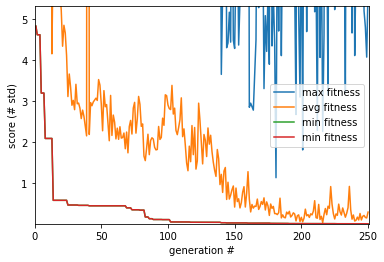

In [10]:
no_list = pickle.load(open("too_rippled_b.p","rb"))
yes_list
#delete_list = ['AP_duration_half_width_change_3.0x','AHP_depth_1.5x','AP_amplitude_diff_1.5x','AP2_AP1_diff_1.5x','AP_amplitude_change_1.5x','AP_duration_half_width_change_3.0x','time_to_second_spike_1.5x','time_constant_1.5x','max_amp_difference_1.5x','inv_fourth_ISI_1.5x','AP_duration_half_width_1.5x','time_to_first_spike_1.5x']

objectives2 = []
for cnt,tt in enumerate(nu_tests):
    feature_name = '%s' % (tt.name)
    if (feature_name not in no_list) and (feature_name in yes_list):
        if feature_name != "time_constant_1.5x":
            ft = NUFeatureAllenMultiSpike(tt,model,cnt,target,check_list,spike_obs,print_stuff=True)
            objective = ephys.objectives.SingletonObjective(
                feature_name,
                ft)
            objectives2.append(objective)

score_calc2 = ephys.objectivescalculators.ObjectivesCalculator(objectives2) 

        
#score_calc2 = ephys.objectivescalculators.ObjectivesCalculator(objectives2) 

MODEL_PARAMS["IZHI"]
cell_evaluator2 = ephys.evaluators.CellEvaluator(
        cell_model=simple_cell,
        param_names=list(MODEL_PARAMS["IZHI"].keys()),
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc2,
        sim='euler')
simple_cell.params_by_names(MODEL_PARAMS["IZHI"].keys())

simple_cell.params;


MODEL_PARAMS["IZHI"]
cell_evaluator2 = ephys.evaluators.CellEvaluator(
        cell_model=simple_cell,
        param_names=list(MODEL_PARAMS["IZHI"].keys()),
        fitness_protocols={twostep_protocol.name: twostep_protocol},
        fitness_calculator=score_calc2,
        sim='euler')
MU =25

optimisation = bpop.optimisations.DEAPOptimisation(
        evaluator=cell_evaluator2,
        offspring_size = MU,
        map_function = dask_map_function,
        selector_name='IBEA',mutpb=0.1,cxpb=0.35)#,seeded_pop=[cp['final_pop'],cp['hall_of_fame']])
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=150)


gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')
plt.plot(gen_numbers, max_fitness, label='max fitness')
plt.plot(gen_numbers, avg_fitness, label='avg fitness')
plt.plot(gen_numbers, min_fitness, label='min fitness')

plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
#9071000.0
#4144000.0


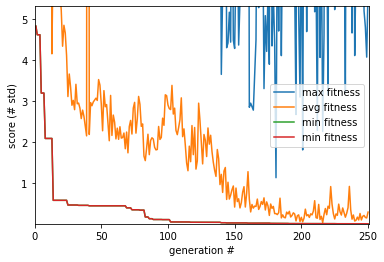

In [11]:
#for i,j in zip(final_pop[-1].fitness.values,objectives2):
#    if i>10:
#        print(i,j.name)

plt.plot(gen_numbers, max_fitness, label='max fitness')
plt.plot(gen_numbers, avg_fitness, label='avg fitness')
plt.plot(gen_numbers, min_fitness, label='min fitness')

plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

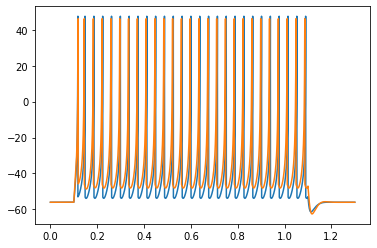

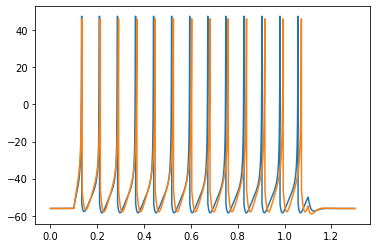

0.0 Spikecount_1.5x
0.0002279756979142036 voltage_base_1.5x
0.009691997104349035 ohmic_input_resistance_vb_ssse_1.5x
0.0 Spikecount_3.0x
0.001239662276666034 peak_voltage_3.0x


In [12]:

best_ind = hall_of_fame[0]
best_ind_dict = cell_evaluator2.param_dict(best_ind)
model = cell_evaluator2.cell_model
cell_evaluator2.param_dict(best_ind)

model.attrs = {str(k):float(v) for k,v in cell_evaluator2.param_dict(best_ind).items()}
opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator2.param_dict(best_ind).items()}
target

from neuronunit.optimisation.optimization_management import dtc_to_rheo, inject_and_plot_model30,check_bin_vm30,check_bin_vm15

vm301,vm151,_,_,target = inject_and_plot_model30(target)
vm302,vm152,_,_,opt = inject_and_plot_model30(opt)
check_bin_vm30(target,opt)
check_bin_vm15(target,opt)
for i,j in zip(best_ind.fitness.values,objectives2):
   print(i,j.name)


In [13]:
print([o.name for o in objectives2])

['Spikecount_1.5x', 'voltage_base_1.5x', 'ohmic_input_resistance_vb_ssse_1.5x', 'Spikecount_3.0x', 'peak_voltage_3.0x']


In [14]:
#def hof_to_euclid
def hof_to_euclid_4(hof,MODEL_PARAMS,target,ranges=True):
    lengths = {}
    tv = 1
    cnt = 0
    constellation0 = hof[0]
    constellation1 = hof[1]
    subset = list(MODEL_PARAMS.keys())
    tg = target.dtc_to_gene(subset_params=subset)
    if len(MODEL_PARAMS)==1:
        
        ax = plt.subplot()
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))

            x = sorted([h[cnt] for h in hof])
            y = [np.sum(h.fitness.values) for h in hof]
            tgene = tg[cnt]
            yg = 0
        plt.plot(x,y)
            

        ax.scatter(x, y, c='b', marker='o',label='samples')
        ax.scatter(tgene, yg, c='r', marker='*',label='target')
        if ranges:
            ax.set_xlim(np.min(hof),np.max(hof))
            ax.set_xlabel(k)
        #ax.plot(x,y)

        ax.legend()

        plt.show()

#def animate(i):

def movie(hof,MODEL_PARAMS,target,max_height):
    lengths = {}
    tv = 1
    cnt = 0
    subset = list(MODEL_PARAMS.keys())
    tg = target.dtc_to_gene(subset_params=subset)
    if len(MODEL_PARAMS)==1:
        plt.clf()
        ax = plt.subplot()

        x =  hof[cnt] 
        y = sum(hof.fitness.values)
        tgene = tg[cnt]
        yg = 0

        ax.scatter(x, y, c='b', marker='o',label='samples')
        #ax.plot(x,y)
        ax.scatter(tgene, yg, c='r', marker='*',label='target')
        ax.set_xlim(np.min(MODEL_PARAMS[subset[0]]),np.max(MODEL_PARAMS[subset[0]]))
        ax.set_ylim(0,max_height)

        ax.set_xlabel(k)

        return ax,plt


In [15]:


def threshold_detection2(signal, threshold=0.0, sign='above'):
    """
    Returns the times when the analog signal crosses a threshold.
    Usually used for extracting spike times from a membrane potential. 
    Adapted from version in NeuroTools.   

    Parameters
    ----------
    signal : neo AnalogSignal object
        'signal' is an analog signal.
    threshold : A quantity, e.g. in mV  
        'threshold' contains a value that must be reached 
        for an event to be detected.
    sign : 'above' or 'below'
        'sign' determines whether to count thresholding crossings
        that cross above or below the threshold.  
    format : None or 'raw'
        Whether to return as SpikeTrain (None) 
        or as a plain array of times ('raw').

    Returns
    -------
    result_st : neo SpikeTrain object
        'result_st' contains the spike times of each of the events (spikes)
        extracted from the signal.  
    """

    assert threshold is not None, "A threshold must be provided"

    if sign is 'above':
        cutout = np.where(signal > threshold)[0]
    elif sign in 'below':
        cutout = np.where(signal < threshold)[0]

    if len(cutout) <= 0:
        events = np.zeros(0)
        return np.array([0])
    else:
        take = np.where(np.diff(cutout)>1)[0]+1
        take = np.append(0,take)
        return take
        #time = signal.times
        #events = time[cutout][take]
   # return len(events)

In [16]:
sub_MODEL_PARAMS = copy.copy(MODEL_PARAMS['IZHI'])


sub_MODEL_PARAMS
hof_to_euclid_4(hall_of_fame,sub_MODEL_PARAMS,target)
sub_MODEL_PARAMS
hof_to_euclid_4(list(hist.genealogy_history.values()),sub_MODEL_PARAMS,target)#,ranges=small)
subset = list(sub_MODEL_PARAMS.keys())
tg = target.dtc_to_gene(subset_params=subset)
tg
MODEL_PARAMS['IZHI']
tg


# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures

import pickle


from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
#untractable=[]
#tractable=[]
def ripple_detection(hof,MODEL_PARAMS,target,objectives2,max_height, show_hard=True):
    lengths = {}
    tv = 1
    cnt = 0
    subset = list(MODEL_PARAMS.keys())
    tg = target.dtc_to_gene(subset_params=subset)
    good_for_opt = []
    know_for_future_opt = []
    for i,f in enumerate(hof[0].fitness.values):    
        plt.clf()
        lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))
        
        # debug change this 200.
        x_plot = np.linspace(np.abs(v[1]),np.abs(v[0]),200)

        X_plot = x_plot[:, np.newaxis]

        hof_x = sorted([ h for h in hof ])

        y = [ h.fitness.values[i] for h in hof_x ] 
        tgene = tg[cnt]
        yg = 0
        model = make_pipeline(PolynomialFeatures(6), Ridge())

        model.fit(hof_x, y)
        model.predict(X_plot)
        y_plot = model.predict(X_plot)
        y_thresh = np.mean(y_plot)
        n_crosses = threshold_detection2(y, threshold=y_thresh, sign='above')
        
        if n_crosses is not None:# is not None:
            untractable.append(objectives2[i].name)
            if show_hard:
                if len(n_crosses)>4:
                    ax = plt.subplot()
                    plt.title(objectives2[i].name)


                    plt.plot(hof_x,y)
                    ax.scatter(hof_x, y, c='b', marker='o',label='samples')
                    ax.scatter(tgene, yg, c='r', marker='*',label='target')
                    ax.set_xlim(np.min(hof),np.max(hof))
                    ax.set_xlabel(k)

                    plt.plot(X_plot, y_plot)
                    ax.legend()
                    plt.show()
                    know_for_future_opt.append(objectives2[i].name)
                
        if len(n_crosses)<5:
            tractable.append(tractable)
            if not show_hard:
                ax = plt.subplot()

                plt.title(objectives2[i].name)


                plt.plot(hof_x,y)
                ax.scatter(hof_x, y, c='b', marker='o',label='samples')
                ax.scatter(tgene, yg, c='r', marker='*',label='target')
                ax.set_xlim(np.min(hof),np.max(hof))
                ax.set_xlabel(k)

                plt.plot(X_plot, y_plot)
                ax.legend()
                plt.show()
                good_for_opt.append(objectives2[i].name)

    if show_hard:
        pickle.dump(know_for_future_opt,open('too_rippled.p','wb'))
    else:
        pickle.dump(good_for_opt,open('tame.p','wb'))

    return 


In [17]:
pop = list(hist.genealogy_history.values())
max_height = np.max([sum(i.fitness.values) for i in pop])

ripple_detection(pop,sub_MODEL_PARAMS,target,objectives2,max_height)#,ranges=small)


ValueError: X shape does not match training shape

<Figure size 432x288 with 0 Axes>

In [ ]:
temp = list(hist.genealogy_history.values())
max_height = np.max([sum(i.fitness.values) for i in temp])
ripple_detection(list(hist.genealogy_history.values()),sub_MODEL_PARAMS,target,objectives2,max_height,show_hard=False)


In [ ]:
pred_collector = []
sum_pred_collector = []


model.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}
opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}

opt.tests = aug_nu_tests

plotxvec = np.linspace(MODEL_PARAMS['IZHI']['a'][0],MODEL_PARAMS['IZHI']['a'][1],20)
for a in plotxvec:
    opt.attrs['a'] = a
    opt.self_evaluate()
    for t in opt.tests:
        try:
            t.prediction['value'] = t.prediction['mean']
        except:
            pass
    values = [test.prediction['value'] for test in opt.tests]
    pred_collector.append(values)
    sum_pred_collector.append(np.sum([values]))
#plt.title('sum of errors')
#plt.plot(plotxvec,sum_pred_collector)
#plt.show()


In [ ]:

def spikes2thresholds_debug(spike_waveforms):
    """
    IN:
     spike_waveforms: Spike waveforms, e.g. from get_spike_waveforms().
        neo.core.AnalogSignal
    OUT:
     1D numpy array of spike thresholds, specifically the membrane potential
     at which 1/10 the maximum slope is reached.

    If the derivative contains NaNs, probably because vm contains NaNs
    Return an empty list with the appropriate units

    """
    try:
        n_spikes = spike_waveforms.shape[1]
    except:
        return None
        #return thresholds * spike_waveforms.units


    thresholds = []
    if n_spikes > 1:
        # good to know can handle multispikeing
        pass
    for i in range(n_spikes):
        s = spike_waveforms[:, i].squeeze()
        s = np.array(s)
        dvdt = np.diff(s)
        for j in dvdt:
            if math.isnan(j):
                return thresholds * spike_waveforms.units
        try:
            trigger = dvdt.max()/10.0
        except:
            return None
            # try this next.
            # return thresholds * spike_waveforms.units

        try:
            x_loc = np.where(dvdt >= trigger)[0][0]
            
            thresh = (s[x_loc]+s[x_loc+1])/2
            
        except:
            thresh = None
        thresholds.append(thresh)
        plt.plot(s.times,s.magnitude)        
        plt.scatter(x_loc,thresh)
        plt.show()
        #plt.savefig("debug_threshold.png")
        
    return thresholds * spike_waveforms.units


In [ ]:

best_ind = hall_of_fame[0]
best_ind_dict = cell_evaluator.param_dict(best_ind)
model = cell_evaluator.cell_model
cell_evaluator.param_dict(best_ind)
model.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}
opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}
opt = opt.attrs

#opt.tests = aug_nu_tests

How do measurements
from the standard suite vary 
with changes in 'a'?

Note these are not scores or like in the above tests, but simply how do measurements change with changes in 'a'

In this we see sometimes 'a' causes ripples in very basic measurements.

In [ ]:
names = [test.name for test in opt.tests]
import matplotlib.pyplot as plt


def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

for i in range(0,len(pred_collector[0])):
    plt.clf()
    plt.title(names[i])
    measurement = [val[i] for val in pred_collector]
    plt.plot(plotxvec,measurement)
    
    #from scipy.interpolate import spline
    #from scipy.interpolate import interp1d

   # xnew = np.linspace(plotxvec[0],plotxvec[1],300) #300 represents number of points to make between T.min and T.max

    #measurement_smooth = interp1d(T,measurement,xnew)

    
    #x = np.linspace(0, 10, num=11, endpoint=True)
    #y = np.cos(-x**2/9.0)
    #f1 = interp1d(plotxvec, measurement, kind='nearest')
    #f2 = interp1d(plotxvec, measurement, kind='zero')
    #f3 = interp1d(plotxvec, measurement, kind='quadratic')

    
    plt.plot(plotxvec,smoothTriangle(measurement,14))
    #plt.plot(plotxvec,f2)
    #plt.plot(plotxvec,f3)

    plt.show()


In [ ]:
attrs = {k:np.mean(v) for k,v in MODEL_PARAMS["IZHI"].items()}
from neuronunit.capabilities.spike_functions import get_spike_waveforms, spikes2widths, spikes2thresholds
from quantities import ms
from neuronunit.tests.base import AMPL, DELAY, DURATION
from neuronunit.optimisation.data_transport_container import DataTC
for slider_value in np.linspace(0.01, 0.1, 100):
  #print(slider_value)

  dtc = DataTC(backend="IZHI",attrs=attrs)
  dtc.attrs['a'] = slider_value
  dtc = dtc_to_rheo(dtc)
  model = dtc.dtc_to_model()
  model.attrs = model._backend.default_attrs
  model.attrs.update(dtc.attrs)
  #print(model.attrs)
  uc = {'amplitude':dtc.rheobase,'duration':DURATION,'delay':DELAY}
  model._backend.inject_square_current(uc)
  vm = model.get_membrane_potential()
  #print(np.max(vm)-np.min(vm))
  snippets1 = get_spike_waveforms(vm)#,width=20*ms)
  spikes2thresholds_debug(snippets1)
  #plt.plot(snippets1.times,snippets1.magnitude) 
  plt.plot(vm.times,vm.magnitude) 
  #snippets1 = get_spike_waveforms(vm,width=10*ms)
  #print(spikes2widths(snippets1)[0])
  print(np.max(vm)-spikes2thresholds(snippets1)[0])
  #plt.plot(snippets1.times,snippets1.magnitude) 

plt.show()

In [ ]:
attrs = {k:np.mean(v) for k,v in MODEL_PARAMS["IZHI"].items()}
from neuronunit.capabilities.spike_functions import get_spike_waveforms, spikes2widths, spikes2thresholds
from quantities import ms
from neuronunit.tests.base import AMPL, DELAY, DURATION
from neuronunit.optimisation.data_transport_container import DataTC
for slider_value in np.linspace(0.01, 0.1, 100):
  #print(slider_value)

  dtc = DataTC(backend="IZHI",attrs=attrs)
  dtc.attrs['a'] = slider_value
  dtc = dtc_to_rheo(dtc)
  model = dtc.dtc_to_model()
  model.attrs = model._backend.default_attrs
  model.attrs.update(dtc.attrs)
  #print(model.attrs)
  uc = {'amplitude':dtc.rheobase*1.5,'duration':DURATION,'delay':DELAY}
  model._backend.inject_square_current(uc)
  vm = model.get_membrane_potential()
  #print(np.max(vm)-np.min(vm))
  #snippets1 = get_spike_waveforms(vm)#,width=20*ms)
  plt.clf()
  #plt.plot(snippets1.times,snippets1.magnitude) 
  plt.plot(vm.times,vm.magnitude) 
  #snippets1 = get_spike_waveforms(vm,width=10*ms)
  #print(spikes2widths(snippets1)[0])
  #print(spikes2thresholds(snippets1)[0])
  #plt.plot(snippets1.times,snippets1.magnitude) 

  plt.show()

  plt.clf()
  uc = {'amplitude':dtc.rheobase*3.0,'duration':DURATION,'delay':DELAY}
  model._backend.inject_square_current(uc)
  vm = model.get_membrane_potential()
    
  #plt.plot(snippets1.times,snippets1.magnitude) 
  #plt.plot(vm.times,vm.magnitude) 
  snippets1 = get_spike_waveforms(vm,width=10*ms)
  print(spikes2widths(snippets1)[0])
  print(spikes2thresholds(snippets1)[0])
  #plt.plot(snippets1.times,snippets1.magnitude) 

  #plt.show()

In [ ]:
plt.clf()
#measurement = [float(val[0])-155 for val in pred_collector]
#plt.plot(plotxvec,measurement)
#plt.semilogy()
plotxvec = np.linspace(MODEL_PARAMS['IZHI']['a'][0],MODEL_PARAMS['IZHI']['a'][1]*2,200)

measurement = [val[-1] for val in pred_collector]
plt.plot(plotxvec,measurement)

measurement = [float(val[-2])-75 for val in pred_collector]
plt.plot(plotxvec,measurement)
measurement = [float(val[-3]) for val in pred_collector]
plt.plot(plotxvec,measurement)

#plt.semilogy()
plt.show()

In [ ]:
m = opt.dtc_to_model()
plotyvec = []
plotxvec = np.linspace(MODEL_PARAMS['IZHI']['a'][0],MODEL_PARAMS['IZHI']['a'][1]*2,100)
for a in plotxvec:
    m.attrs['a'] = a
    #print(opt.tests[-2].params)

    plotyvec.append(opt.tests[-2].generate_prediction(m)['value'])
plt.plot(plotxvec,plotyvec)
plt.show()

In [ ]:
from neuronunit.optimisation.optimization_management import inject_and_plot_model, dtc_to_rheo
plotxvec = np.linspace(MODEL_PARAMS['IZHI']['a'][0],MODEL_PARAMS['IZHI']['a'][1],100)
for a in plotxvec:
    opt.attrs['a'] = a
    opt = dtc_to_rheo(opt)
    opt.self_evaluate()
    try:
        out = inject_and_plot_model(opt,plotly=False)
        print(out)
        #vm.show()

    #except:
        plt = inject_and_plot_model(opt,plotly=False)
        print(opt.rheobase)
    #for t in opt.tests:
    #    try:
    #        t.prediction['value'] = t.prediction['mean']
    #    except:
    #        pass
    #values = [test.prediction['value'] for test in opt.tests]
    #pred_collector.append(values)
    #sum_pred_collector.append(np.sum([values]))
#plt.title('sum of errors')
#plt.plot(plotxvec,sum_pred_collector)
#plt.show()

In [ ]:

plotxvec = np.linspace(MODEL_PARAMS['IZHI']['a'][0],MODEL_PARAMS['IZHI']['a'][1],100)
for a in plotxvec:
    opt.attrs['a'] = a
    opt = dtc_to_rheo(opt)
    opt.self_evaluate()
    vm,plt = inject_and_plot_model(opt)
    plt.show()
    for t in opt.tests:
        try:
            t.prediction['value'] = t.prediction['mean']
        except:
            pass
    values = [test.prediction['value'] for test in opt.tests]
    pred_collector.append(values)
    sum_pred_collector.append(np.sum([values]))
plt.title('sum of errors')
plt.plot(plotxvec,sum_pred_collector)
plt.show()

# are changes in b just as dramatic?

In [ ]:
#from neuronunit.optimisation.model_parameters import MODEL_PARAMS as mp
print(mp['IZHI'])
pred_collector = []
sum_pred_collector = []

plotxvec = np.linspace(-2,15,100)
opt.attrs['a'] = np.mean(MODEL_PARAMS['IZHI']['a'])
for b in plotxvec:
    
    opt.attrs['b'] = b
    opt.self_evaluate()
    for t in opt.tests:
        try:
            t.prediction['value'] = t.prediction['mean']
        except:
            pass
    values = [test.prediction['value'] for test in opt.tests]
    pred_collector.append(values)
    sum_pred_collector.append(np.sum([values]))


In [ ]:
#plt.title('sum of errors')
#plt.plot(plotxvec,sum_pred_collector)
#plt.show()

names = [test.name for test in opt.tests]

for i in range(0,len(pred_collector[0])):
    plt.clf()
    plt.title(names[i])
    plt.plot(plotxvec,[val[i] for val in pred_collector])
    plt.show()


And **c**?

In [ ]:
#from neuronunit.optimisation.model_parameters import MODEL_PARAMS as mp
print(mp['IZHI'])
pred_collector = []
sum_pred_collector = []

opt.attrs['a'] = np.mean(MODEL_PARAMS['IZHI']['a'])
opt.attrs['b'] = np.mean(plotxvec)
plotxvec = np.linspace(-60,-40,100)
 
for c in plotxvec:
    
    opt.attrs['c'] = c
    opt.self_evaluate()
    for t in opt.tests:
        try:
            t.prediction['value'] = t.prediction['mean']
        except:
            pass
    values = [test.prediction['value'] for test in opt.tests if test.prediction['value'] is not None]
    pred_collector.append(values)
    sum_pred_collector.append(np.sum([values]))

names = [test.name for test in opt.tests]

for i in range(0,len(pred_collector[0])):
    plt.clf()
    plt.title(names[i])
    plt.plot(plotxvec,[val[i] for val in pred_collector])
    plt.show()

And **C**?

In [ ]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS as mp
print(mp['IZHI'])
pred_collector = []
sum_pred_collector = []

#opt.attrs['a'] = np.mean(MODEL_PARAMS['IZHI']['a'])
#opt.attrs['b'] = np.mean(plotxvec)
opt.attrs['c'] = np.mean(plotxvec)

plotxvec = np.linspace(50,200,100)
 
for C in plotxvec:
    
    opt.attrs['C'] = C
    opt.self_evaluate()
    for t in opt.tests:
        try:
            t.prediction['value'] = t.prediction['mean']
        except:
            pass
    values = [test.prediction['value'] for test in opt.tests if test.prediction['value'] is not None]
    pred_collector.append(values)
    sum_pred_collector.append(np.sum([values]))

names = [test.name for test in opt.tests]

for i in range(0,len(pred_collector[0])):
    plt.clf()
    plt.title(names[i])
    plt.plot(plotxvec,[val[i] for val in pred_collector])
    plt.show()

In [ ]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS as mp
print(mp['IZHI'])
pred_collector = []
sum_pred_collector = []

#opt.attrs['a'] = np.mean(MODEL_PARAMS['IZHI']['a'])
#opt.attrs['b'] = np.mean(plotxvec)
opt.attrs['C'] = np.mean(plotxvec)

plotxvec = np.linspace(10,150,100)
 
for d in plotxvec:
    
    opt.attrs['d'] = d
    opt.self_evaluate()
    for t in opt.tests:
        try:
            t.prediction['value'] = t.prediction['mean']
        except:
            pass
    values = [test.prediction['value'] for test in opt.tests if test.prediction['value'] is not None]
    pred_collector.append(values)
    sum_pred_collector.append(np.sum([values]))

names = [test.name for test in opt.tests]

for i in range(0,len(pred_collector[0])):
    plt.clf()
    plt.title(names[i])
    plt.plot(plotxvec,[val[i] for val in pred_collector])
    plt.show()

In [ ]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS as mp
print(mp['IZHI'])
pred_collector = []
sum_pred_collector = []

#opt.attrs['a'] = np.mean(MODEL_PARAMS['IZHI']['a'])
#opt.attrs['b'] = np.mean(plotxvec)
opt.attrs['d'] = np.mean(plotxvec)

plotxvec = np.linspace(0.7,1.6,100)
#print(plotxvec)
for k in plotxvec:
    
    opt.attrs['k'] = k
    #print(opt.attrs)
    opt.self_evaluate()
    for t in opt.tests:
        try:
            t.prediction['value'] = t.prediction['mean']
        except:
            pass
    values = [test.prediction['value'] for test in opt.tests if test.prediction['value'] is not None]
    pred_collector.append(values)
    sum_pred_collector.append(np.sum([values]))

names = [test.name for test in opt.tests]

for i in range(0,len(pred_collector[0])):
    plt.clf()
    plt.title(names[i])
    plt.plot(plotxvec,[val[i] for val in pred_collector])
    plt.show()

In [ ]:

from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline
import time
import pylab as pl
from IPython import display
#for i in range(10):

temp = list(hist.genealogy_history.values())
max_height = np.max([sum(i.fitness.values) for i in temp])
#movies = True
#if movies:
for i,current in enumerate(list(hist.genealogy_history.values())):
    max_height
    ax,pl = movie(current,sub_MODEL_PARAMS,target,max_height)
    pl.title('gene number {0}'.format(i))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.05)
    

    
    
    
#anim = animation.FuncAnimation(fig, animate, init_func=init,
#                               frames=100, interval=20, blit=True)    
    
#HTML(anim.to_html5_video())


In [ ]:
target.attrs

In [ ]:
hall_of_fame[1]





In [ ]:



MU = 50
cp = {}
cp['halloffame'] = hall_of_fame
cp['population'] = final_pop
#seed_pop = cp['halloffame']
#cp = pickle.load(open('results_100.p', "rb"))

#seed_pop.extend(cp['pop'])
optimisation = bpop.optimisations.DEAPOptimisation(
        evaluator=cell_evaluator2,
        offspring_size = MU,
        map_function = dask_map_function,
        selector_name='IBEA',mutpb=0.1,cxpb=0.2),
        #seeded_pop=[cp['halloffame'],cp['population']])
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=50)


In [ ]:


# The optimisation has return us 4 objects: final population, hall of fame, statistical logs and history. 
# 
# The final population contains a list of tuples, with each tuple representing the two parameters of the model


#print('Final population: ', final_pop)


# The best individual found during the optimisation is the first individual of the hall of fame

best_ind = hall_of_fame[0]
#print('Best individual: ', best_ind)
#print('Fitness values: ', best_ind.fitness.va


# We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dict of the parameters


best_ind_dict = cell_evaluator.param_dict(best_ind)
#print(cell_evaluator.evaluate_with_dicts(best_ind_dict))


model = cell_evaluator.cell_model
cell_evaluator.param_dict(best_ind)
model.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}



opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}

check_binary_match(target,opt)
inject_and_plot_passive_model(opt,second=target,plotly=False)



In [ ]:
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')

plt.clf()
plt.plot(gen_numbers, max_fitness, label='max fitness')
plt.plot(gen_numbers, avg_fitness, label='avg fitness')
plt.plot(gen_numbers, min_fitness, label='min fitness')

plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.yscale('log')

plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
#plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

In [ ]:
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
avg_fitness = logs.select('avg')

plt.clf()
fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(1,1)

plt.plot(gen_numbers, min_fitness, label='min fitness')
#ax.semilogy()
#ax.set_yscale('log')
plt.yscale('log')

plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
#plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 
plt.show()

In [ ]:
inject_and_plot_passive_model(opt,second=target,plotly=False)
best_ind_dict = cell_evaluator.param_dict(best_ind)
objectives = cell_evaluator.evaluate_with_dicts(best_ind_dict)

In [ ]:
best_ind_dict = cell_evaluator.param_dict(best_ind)
objectives = cell_evaluator.evaluate_with_dicts(best_ind_dict)

model = cell_evaluator.cell_model
cell_evaluator.param_dict(best_ind)
model.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}

opt = model.model_to_dtc()
opt.attrs = {str(k):float(v) for k,v in cell_evaluator.param_dict(best_ind).items()}
from neuronunit.optimisation.optimization_management import dtc_to_rheo, inject_and_plot_model30,check_bin_vm30,check_bin_vm15
opt = dtc_to_rheo(opt)
opt.rheobase
opt.attrs;


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



def hof_to_euclid(hof,MODEL_PARAMS,target):
    lengths = {}
    tv = 1
    cnt = 0
    constellation0 = hof[0]
    constellation1 = hof[1]
    subset = list(sub_MODEL_PARAMS.keys())
    tg = target.dtc_to_gene(subset_params=subset)
    if len(MODEL_PARAMS)==1:
        
        ax = plt.subplot()
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))

            x = [h[cnt] for h in hof]
            y = [0 for h in hof]
            ax.set_xlim(v[0],v[1])
            ax.set_xlabel(k)
            tgene = tg[cnt]
            yg = 0

        ax.scatter(x, y, c='b', marker='o',label='samples')
        ax.scatter(tgene, yg, c='r', marker='*',label='target')
        ax.legend()

        plt.show()
    
    
    if len(MODEL_PARAMS)==2:
        
        ax = plt.subplot()
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))
                
            if cnt==0:
                tgenex = tg[cnt]
                x = [h[cnt] for h in hof]
                ax.set_xlim(v[0],v[1])
                ax.set_xlabel(k)
            if cnt==1:
                tgeney = tg[cnt]

                y = [h[cnt] for h in hof]
                ax.set_ylim(v[0],v[1])
                ax.set_ylabel(k)
            cnt+=1

        ax.scatter(x, y, c='r', marker='o',label='samples',s=5)
        ax.scatter(tgenex, tgeney, c='b', marker='*',label='target',s=11)
        ax.legend()
        plt.show()
    if len(MODEL_PARAMS)==3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for k,v in MODEL_PARAMS.items():
            lengths[k] = np.abs(np.abs(v[1])-np.abs(v[0]))
        
            if cnt==0:
                tgenex = tg[cnt]

                x = [h[cnt] for h in hof]
                ax.set_xlim(v[0],v[1])
                ax.set_xlabel(k)
            if cnt==1:
                tgeney = tg[cnt]

                y = [h[cnt] for h in hof]
                ax.set_ylim(v[0],v[1])
                ax.set_ylabel(k)
            if cnt==2:
                tgenez = tg[cnt]

                z = [h[cnt] for h in hof]
                ax.set_zlim(v[0],v[1])
                ax.set_zlabel(k)

            cnt+=1
        ax.scatter(x, y, z, c='r', marker='o')
        ax.scatter(tgenex, tgeney,tgenez, c='b', marker='*',label='target',s=21)

        plt.show()
        
sub_MODEL_PARAMS = copy.copy(MODEL_PARAMS['IZHI'])


sub_MODEL_PARAMS
hof_to_euclid(hall_of_fame,sub_MODEL_PARAMS,target)
sub_MODEL_PARAMS
hof_to_euclid(final_pop,sub_MODEL_PARAMS,target)
subset = list(sub_MODEL_PARAMS.keys())
tg = target.dtc_to_gene(subset_params=subset)
tg
MODEL_PARAMS['IZHI']
tg

In [ ]:
#for gene in list(hist.genealogy_history.values()):
hof_to_euclid(list(hist.genealogy_history.values()),sub_MODEL_PARAMS,target)
sub_MODEL_PARAMS

In [ ]:
from utils import basic_expVar

In [ ]:
opt = dtc_to_rheo(opt)
print(opt.rheobase)
print(target.rheobase)

In [ ]:

check_binary_match(opt,target,plotly=False,snippets=False)
check_binary_match(opt,target,plotly=False,snippets=True)
print(basic_expVar(target.vmrh, opt.vmrh), 'variancce explained ratio at rheobase')


In [ ]:
params = {}
params['injected_square_current'] = {}
#if v.name in str('RestingPotentialTest'):
params['injected_square_current']['delay'] = PASSIVE_DELAY
params['injected_square_current']['duration'] = PASSIVE_DURATION
params['injected_square_current']['amplitude'] = 0.0*pq.pA    

In [ ]:

opt_model = opt.dtc_to_model()
opt_model.inject_square_current(params)
opt_vm = opt_model.get_membrane_potential()
opt_vm[-1]

In [ ]:
target_model = target.dtc_to_model()
target_model.inject_square_current(params)
target_vm = target_model.get_membrane_potential()
target_vm[-1]

In [ ]:
best_ind = hall_of_fame[1]
#print('Best individual: ', best_ind)
#print('Fitness values: ', best_ind.fitness.values)


# We can evaluate this individual and make use of a convenience function of the cell evaluator to return us a dict of the parameters


best_ind_dict = cell_evaluator.param_dict(best_ind)
#print(cell_evaluator.evaluate_with_dicts(best_ind_dict))


model = cell_evaluator.cell_model
dtc= model.model_to_dtc()
opt = dtc_to_rheo(opt)
print(opt.rheobase)
print(target.rheobase)

In [ ]:
#model.rheobase
objectives

In [ ]:

best_ind_dict = cell_evaluator.param_dict(best_ind)
objectives = cell_evaluator.evaluate_with_dicts(best_ind_dict)

objectives2 = cell_evaluator2.evaluate_with_dicts(best_ind_dict)


In [ ]:
import pandas as pd
import seaborn as sns
logbook = logs
#scores = [ m for m in logs ]
'''
list_of_dicts = []
df1 = pd.DataFrame()
genes=[]
for _,v in hist.genealogy_history.items():
    genes.append(v.fitness.values)
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)

'''
#MU =14
genes=[]
min_per_generations = []
for i,v in hist.genealogy_history.items():
    if i%MU==0:
        min_per_gen = sorted([(gene,np.min(gene)) for gene in genes],key=lambda x: x[1])
        min_per_generations.append(min_per_gen[0][0])
        genes =[]
    genes.append(v.fitness.values)
    
df2 = pd.DataFrame()
scores = []
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    print([i[j] for i in min_per_generations ])
    df2[index] = pd.Series([i[j] for i in min_per_generations ])#, index=df1.index)
df2    


In [ ]:
number=int(np.sqrt(len(df2.columns)))

In [ ]:
import math
box = int(np.sqrt(len(objectives)))
fig,axes = plt.subplots(box,box+1,figsize=(20,20))#math.ceil(len(objectives)/2+1),figsize=(20,20))
#axes[0,0].plot(scores)
#axes[0,0].plot(gen_numbers, min_fitness, label='min fitness')

axes[0,0].set_title('Observation/Prediction Disagreement')
for i,c in enumerate(df2.columns):
    ax = axes.flat[i+1]
    history = df2[c]
    #mn = mean[k.name] 
    #st = std[k.name] 
    #history = [(j[i]-mn)/st for j in scores ]
    #ax.axhline(y=mn , xmin=0.02, xmax=0.99,color='red',label='best candidate sampled')

    #ax.axvline(x=min_x , ymin=0.02, ymax=0.99,color='blue',label='best candidate sampled')
    ax.plot(history)
    ax.set_title(str(c))
    #bigger = np.max([np.max(history),mn])
    #smaller = np.max([np.min(history),mn])

    #ax.set_ylim([np.min(history),np.max(history)])
    #ax.set_ylabel(str(front[0].dtc.tests[i].observation['std'].units))
axes[0,0].set_xlabel("Generation")
axes[0,0].set_ylabel("standardized error")

plt.tight_layout()
#if figname is not None:
#    plt.savefig(figname)
#else:
plt.show()

In [ ]:

logbook = logs
#scores = [ m for m in logs ]
list_of_dicts = []
df1 = pd.DataFrame()
genes=[]
for _,v in hist.genealogy_history.items():
    genes.append(v.fitness.values)
for j,i in enumerate(objectives2.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)


    
#if normalize:
#    a = (a - mean(a)) / (std(a) * len(a))
#    v = (v - mean(v)) /  std(v)

df1=(df1-df1.mean())/df1.std()

corr = df1.corr()#.normalize()
fig =plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)
plt.show()
print(np.sum(np.sum(corr)))

In [ ]:

    
logbook = logs
list_of_dicts = []
df1 = pd.DataFrame()
genes=[]
for _,v in hist.genealogy_history.items():
    genes.append(v.fitness.values)
for j,i in enumerate(objectives2.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)


    
#if normalize:
#    a = (a - mean(a)) / (std(a) * len(a))
#    v = (v - mean(v)) /  std(v)

df1=(df1-df1.mean())/df1.std()

corr = df1.corr()#.normalize()
fig =plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)
plt.show()
print(np.sum(np.sum(corr)))

In [ ]:
hist.genealogy_history.keys();

In [ ]:
hist.genealogy_tree.keys();

In [ ]:
import networkx
graph = networkx.DiGraph(hist.genealogy_tree)
graph = graph.reverse()     # Make the graph top-down
per_generation = [(gen,hist.genealogy_history[gen].fitness.values) for gen in graph]

In [ ]:
per_generation

In [ ]:
graph.nodes

In [ ]:
cp['halloffame'][-1].fitness.values

In [ ]:
cp['halloffame'][0].fitness.values

In [ ]:
cp['population'][-1].fitness.values

In [ ]:
final_pop 
hall_of_fame[-1].fitness.values

In [ ]:
len(hall_of_fame)

In [ ]:
plt.plot([i for i in range(len(hall_of_fame),0,-1)],[np.sum(i.fitness.values) for i in hall_of_fame])

In [ ]:
plt.plot([i for i in range(0,len(hall_of_fame))],[np.sum(hall_of_fame[i].fitness.values) for i in range(len(hall_of_fame)-1,-1,-1)])

In [ ]:
genes=[]

for v in hall_of_fame:
    #v = hall_of_fame[j]
    genes.append(v.fitness.values)

#for i in 
#    plt.plot([i for i in range(0,len(hall_of_fame))],[hall_of_fame[i].fitness.values[j] for i in range(len(hall_of_fame)-1,-1,-1)])
#    plt.show()
df1 = pd.DataFrame()

In [ ]:
for j,i in enumerate(objectives.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)

df1=(df1-df1.mean())/df1.std()

corr = df1.corr()
fig =plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)
plt.show()

In [ ]:
for j,i in enumerate(objectives2.keys()):
    index = i.split('.')[0]
    df1[str(index)] = pd.Series(genes).values[j]#, index=df1.index)

df1=(df1-df1.mean())/df1.std()

corr = df1.corr()
fig =plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)
plt.show()